In [3]:
!python inference.py \
--model="attribute_mask_rcnn" \
--checkpoint_path="checkpoints/fashionpedia-spinenet-143/model.ckpt" \
--label_map_file="datasets/fashionpedia_label_map.csv" \
--image_file_pattern="images/test_o5/*0.png" \
--max_boxes_to_draw=15 \
--min_score_threshold=0.5 \
--config_file="configs/yaml/spinenet143_amrcnn.yaml" \
--output_file="output/output_o5t.npy" \
--output_html="output/out_o5t.html"

 - Loading the label map...
 - Loading the checkpoint...
 - Processing image 0...
 - Processing image 1...
 - Processing image 2...
 - Processing image 3...
 - Processing image 4...
 - Processing image 5...
 - Processing image 6...
 - Processing image 7...
 - Processing image 8...
 - Processing image 9...
 - Processing image 10...
 - Processing image 11...
 - Processing image 12...
 - Processing image 13...
 - Processing image 14...
 - Processing image 15...
 - Processing image 16...
 - Processing image 17...
 - Processing image 18...
 - Processing image 19...
 - Processing image 20...
 - Processing image 21...
 - Processing image 22...
 - Processing image 23...
 - Processing image 24...
 - Processing image 25...
 - Processing image 26...
 - Processing image 27...
 - Processing image 28...
 - Processing image 29...
 - Processing image 30...
 - Processing image 31...
 - Processing image 32...
 - Processing image 33...
 - Processing image 34...
 - Processing image 35...
 - Processing im

The system cannot find the path specified.
C:\Users\Kenji\miniforge3\envs\project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Kenji\Desktop\fashionpedia-run\inference.py:242: UserWarning: Flag --model has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  flags.mark_flag_as_required('model')
C:\Users\Kenji\Desktop\fashionpedia-run\inference.py:243: UserWarning: Flag --checkpoint_path has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  flags.mark_flag_as_required('checkpoint_path')
C:\Users\Kenji\Desktop\fashionpedia-run\inference.py:244: UserWarning: Flag --label_map_file has a non-None default value; therefore, mark_flag_as_required will pass even if fl

In [15]:
!python inference.py --model="attribute_mask_rcnn" --checkpoint_path="checkpoints/fashionpedia-spinenet-143/model.ckpt" --label_map_file="datasets/fashionpedia_label_map.csv" --image_file_pattern="images/loveflair_tops/top/**/*.jpg" --max_boxes_to_draw=15 --min_score_threshold=0.5 --config_file="configs/yaml/spinenet143_amrcnn.yaml" --output_file="output/output_lf.npy" --output_html="output/out_lf.html"

^C


In [1]:
!python inference_saved_model.py --saved_model_dir="saved_models" --label_map_file="datasets/fashionpedia_label_map.csv" --image_file_pattern="images/Capture.jpg" --output_html="output_saved"

 - Loading the label map...
 - Loading saved model...
 - processing image 0...


The system cannot find the path specified.
C:\Users\Kenji\miniforge3\envs\project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Kenji\Desktop\fashionpedia-run\inference_saved_model.py:190: UserWarning: Flag --saved_model_dir has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  flags.mark_flag_as_required('saved_model_dir')
C:\Users\Kenji\Desktop\fashionpedia-run\inference_saved_model.py:191: UserWarning: Flag --label_map_file has a non-None default value; therefore, mark_flag_as_required will pass even if flag is not specified in the command line!
  flags.mark_flag_as_required('label_map_file')
C:\Users\Kenji\Desktop\fashionpedia-run\inference_saved_model.py:192: UserWarning: Flag --image_file_pattern has a non-None default va

In [67]:
import tensorflow as tf

model = tf.saved_model.load('saved_models')
# model = tf.saved_model.load('tf2model')
infer = model.signatures['serving_default']

OSError: SavedModel file does not exist at: tf2model\{saved_model.pbtxt|saved_model.pb}

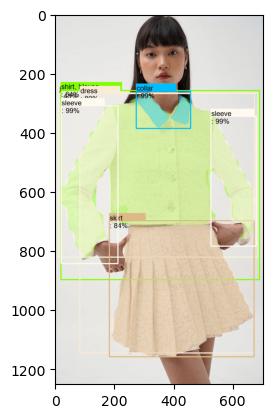

In [66]:
from PIL import Image
import numpy as np
from utils import mask_utils, box_utils
from utils.object_detection import visualization_utils
import matplotlib.pyplot as plt

# Load and preprocess the image
image = Image.open('images/Capture.jpg')
# image = image.resize((640, 640))  # Resize based on your model's input size
image_array = np.array(image) #/ 255.0  # Normalize if required
input_tensor = tf.convert_to_tensor(np.expand_dims(image_array, axis=0), dtype=tf.uint8)

# Perform inference

serving_default_fn = model.signatures['serving_default']
output_results = serving_default_fn(input_tensor)
    
image_with_detections_list = []
label_map_dict = {}
with open('datasets/fashionpedia_label_map.csv', 'r') as csv_file:
      reader = csv_file.readlines()
      for row in reader:
        k, v = row.split(':')
        id_index = int(k)
        name = v
        label_map_dict[id_index] = {
            'id': id_index,
            'name': name,
        }
          
num_detections = int(output_results['num_detections'][0])
np_boxes = output_results['detection_boxes'][0, :num_detections]
width, height = image.size

np_image_info = output_results['image_info'][0]
np_boxes = np_boxes / np.tile(np_image_info[1:2, :], (1, 2))
ymin, xmin, ymax, xmax = np.split(np_boxes, 4, axis=-1)
ymin = ymin * height
ymax = ymax * height
xmin = xmin * width
xmax = xmax * width

np_boxes = np.concatenate([ymin, xmin, ymax, xmax], axis=-1)
np_scores = output_results['detection_scores'][0, :num_detections]
np_classes = output_results['detection_classes'][0, :num_detections]
np_classes = np_classes.numpy().astype(np.int32)
np_attributes = output_results['detection_attributes'][
  0, :num_detections, :]

np_masks = None
if 'detection_masks' in output_results:
    np_masks = output_results['detection_masks'][0, :num_detections]
    np_masks = mask_utils.paste_instance_masks(
        np_masks, box_utils.yxyx_to_xywh(np_boxes), height, width)

np_image = (image_array.reshape(height, width, 3).astype(np.uint8))
image_with_detections = (
          visualization_utils.visualize_boxes_and_labels_on_image_array(
              np_image,
              np_boxes,
              np_classes,
              np_scores,
              label_map_dict,
              instance_masks=np_masks,
              use_normalized_coordinates=False,
              max_boxes_to_draw=15,
              min_score_thresh=0.3))
image_with_detections_list.append(image_with_detections)


plt.imshow(image_with_detections_list[0])
plt.show()

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

def convert_tf1_to_tf2(checkpoint_path, output_prefix):
    """Converts a TF1 checkpoint to TF2.
    
    To load the converted checkpoint, you must build a dictionary that maps
    variable names to variable objects.
    ```
    ckpt = tf.train.Checkpoint(vars={name: variable})  
    ckpt.restore(converted_ckpt_path)

    ```

    Args:
      checkpoint_path: Path to the TF1 checkpoint.
      output_prefix: Path prefix to the converted checkpoint.

    Returns:
      Path to the converted checkpoint.
    """
    vars = {}
    reader = tf.train.load_checkpoint(checkpoint_path)
    dtypes = reader.get_variable_to_dtype_map()
    for key in dtypes.keys():
      vars[key] = tf.Variable(reader.get_tensor(key))
    return tf.train.Checkpoint(vars=vars).save(output_prefix)

convert_tf1_to_tf2( "checkpoints/fashionpedia-spinenet-143/model.ckpt", 'tf2_model')

C:\Users\Kenji\miniforge3\envs\project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'tf2_model-1'

In [122]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import csv
import io

from absl import flags
from absl import logging

import numpy as np
from PIL import Image
from pycocotools import mask as mask_api
import tensorflow.compat.v1 as tf

from dataloader import mode_keys
from configs import factory as config_factory
from modeling import factory as model_factory
from utils import box_utils
from utils import input_utils
from utils import mask_utils
from utils.object_detection import visualization_utils
from hyperparameters import params_dict


  # Load the label map.
label_map_dict = {}
with tf.gfile.Open('datasets/fashionpedia_label_map.csv', 'r') as csv_file:
    reader = csv.reader(csv_file, delimiter=':')
    for row in reader:
        if len(row) != 2:
          raise ValueError('Each row of the csv label map file must be in '
                           '`id:name` format.')
        id_index = int(row[0])
        name = row[1]
        label_map_dict[id_index] = {
            'id': id_index,
            'name': name,
        }


params = config_factory.config_generator('attribute_mask_rcnn')
if True:
    params = params_dict.override_params_dict(
        params, 'configs/yaml/spinenet143_amrcnn.yaml', is_strict=True)
    params = params_dict.override_params_dict(
      params, '', is_strict=True)
    params.override({
      'architecture': {
          'use_bfloat16': False,  # The inference runs on CPU/GPU.
      },
    }, is_strict=True)
    params.validate()
    params.lock()

model = model_factory.model_generator(params)

with tf.Graph().as_default():
    image_input = tf.placeholder(shape=(), dtype=tf.string)
    image = tf.io.decode_image(image_input, channels=3)
    image.set_shape([None, None, 3])

    image = input_utils.normalize_image(image)
    # image_size = [1108, 792] #[640,640]
    image_size = [640,640]
    image, image_info = input_utils.resize_and_crop_image(
        image,
        image_size,
        image_size,
        aug_scale_min=1.0,
        aug_scale_max=1.0)
    image.set_shape([image_size[0], image_size[1], 3])

    # batching.
    images = tf.reshape(image, [1, image_size[0], image_size[1], 3])
    images_info = tf.expand_dims(image_info, axis=0)

    # model inference
    outputs = model.build_outputs(
        images, {'image_info': images_info}, mode=mode_keys.PREDICT)

    outputs['detection_boxes'] = (
        outputs['detection_boxes'] / tf.tile(images_info[:, 2:3, :], [1, 1, 2]))

    predictions = outputs

    # Create a saver in order to load the pre-trained checkpoint.
    saver = tf.train.Saver()

    image_with_detections_list = []
      
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction = 0.3


    with tf.Session(config=config) as sess:
      print(' - Loading the checkpoint...')
      saver.restore(sess, 'checkpoints/fashionpedia-spinenet-143/model.ckpt')

      res = []
      # image_files = tf.gfile.Glob('../project-cluster-index/lovebonito_tops/top/**/*.jpg')
      image_files = tf.gfile.Glob('images/Capture.jpg')

      for i, image_file in enumerate(image_files):
        print(' - Processing image %d...' % i)

        with tf.gfile.GFile(image_file, 'rb') as f:
          image_bytes = f.read()
          image_cnv = Image.open(io.BytesIO(image_bytes))
 
          ##########
          # Create a BytesIO object to hold the converted JPEG bytes
          jpeg_bytes_io = io.BytesIO()
          
          # Convert the image to JPEG format and save to the BytesIO object
          image_cnv.convert("RGB").save(jpeg_bytes_io, format="JPEG")
          
          # Get the byte data for the JPEG image
          image_bytes = jpeg_bytes_io.getvalue()
          #############

        image = Image.open(image_file)
        image = image.convert('RGB')  # needed for images with 4 channels.
        width, height = image.size
        np_image = (np.array(image.getdata())
                    .reshape(height, width, 3).astype(np.uint8))
        plt.imshow(np_image)
        # break

        predictions_np = sess.run(
            predictions, feed_dict={image_input: image_bytes }) # image_bytes

        num_detections = int(predictions_np['num_detections'][0])
        np_boxes = predictions_np['detection_boxes'][0, :num_detections]
        np_scores = predictions_np['detection_scores'][0, :num_detections]
        np_classes = predictions_np['detection_classes'][0, :num_detections]
        np_classes = np_classes.astype(np.int32)
        np_attributes = predictions_np['detection_attributes'][
            0, :num_detections, :]
        np_masks = None
        if 'detection_masks' in predictions_np:
          instance_masks = predictions_np['detection_masks'][0, :num_detections]
          np_masks = mask_utils.paste_instance_masks(
              instance_masks, box_utils.yxyx_to_xywh(np_boxes), height, width)
          encoded_masks = [
              mask_api.encode(np.asfortranarray(np_mask))
              for np_mask in list(np_masks)]

        res.append({
            'image_file': image_file,
            'boxes': np_boxes,
            'classes': np_classes,
            'scores': np_scores,
            'attributes': np_attributes,
            'masks': encoded_masks,
        })

        # image_with_detections = (
        #     visualization_utils.visualize_boxes_and_labels_on_image_array(
        #         np_image,
        #         np_boxes,
        #         np_classes,
        #         np_scores,
        #         label_map_dict,
        #         instance_masks=np_masks,
        #         use_normalized_coordinates=False,
        #         max_boxes_to_draw=15,
        #         min_score_thresh=0.5))
        # image_with_detections_list.append(image_with_detections)

output = res

 - Loading the checkpoint...
INFO:tensorflow:Restoring parameters from checkpoints/fashionpedia-spinenet-143/model.ckpt


INFO:tensorflow:Restoring parameters from checkpoints/fashionpedia-spinenet-143/model.ckpt


 - Processing image 0...


In [124]:
import numpy as np

In [2]:
output = np.load('output/output_o5t.npy', allow_pickle=True)

In [150]:
for i in output:
    for k, v in i.items():
        if k == 'image_file':
            print('='*40, v, sep='\n')
            continue
        if type(v) == list:
            print( k, len(v))
        else:
            print( k, v.shape)

images\Capture.jpg
boxes (6, 4)
classes (6,)
scores (6,)
attributes (6, 294)
masks 6


29:collar
 [263.8448  274.52472 386.3789  458.34753] 0.9994697


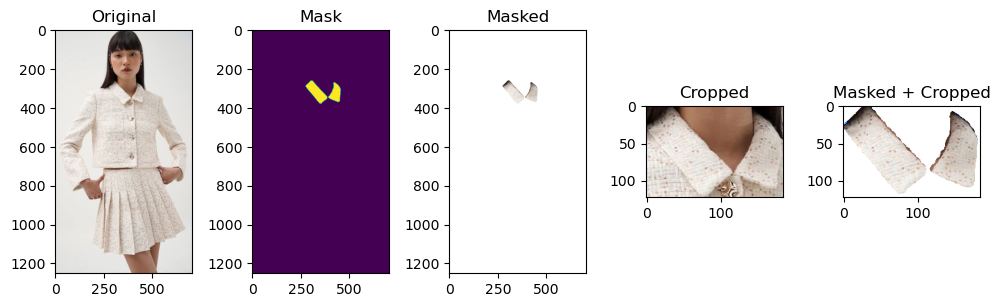

32:sleeve
 [314.95062  18.94537 830.7053  214.31274] 0.9993543


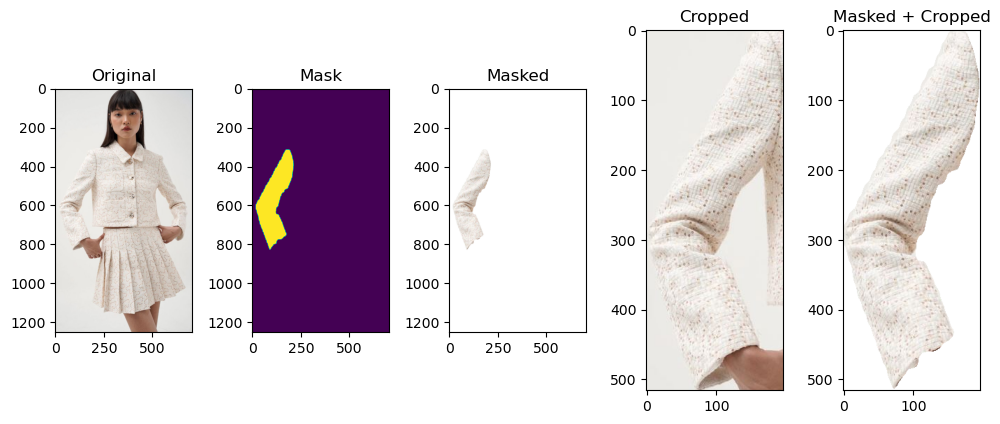

32:sleeve
 [346.251   527.8084  786.14777 682.8376 ] 0.99909806


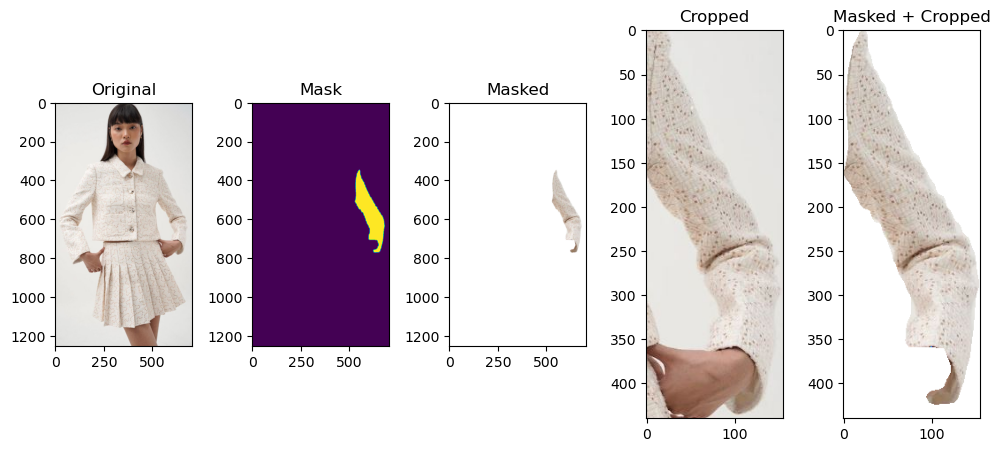

9:skirt
 [ 708.6062   183.13821 1158.657    673.0401 ] 0.9935899


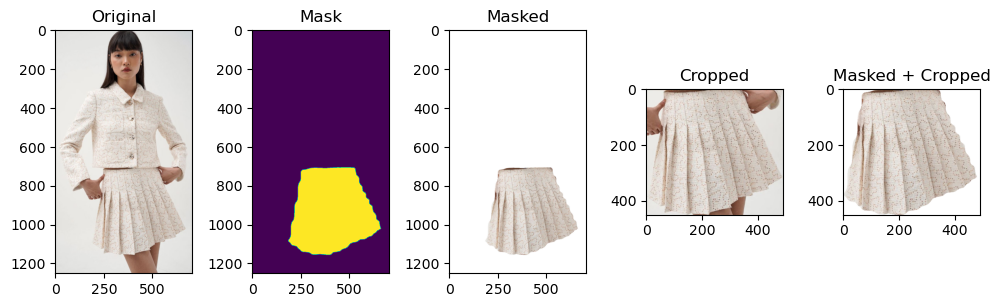

1:shirt, blouse
 [267.0554    18.554026 843.8311   667.2381  ] 0.9433877


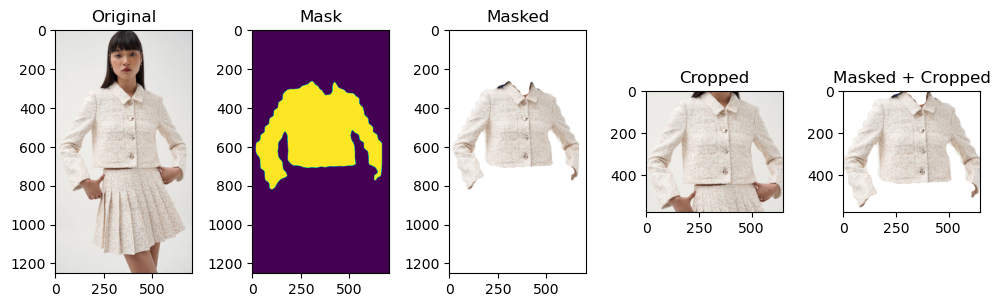

5:jacket
 [276.06705   15.806204 848.8061   684.2172  ] 0.11963519


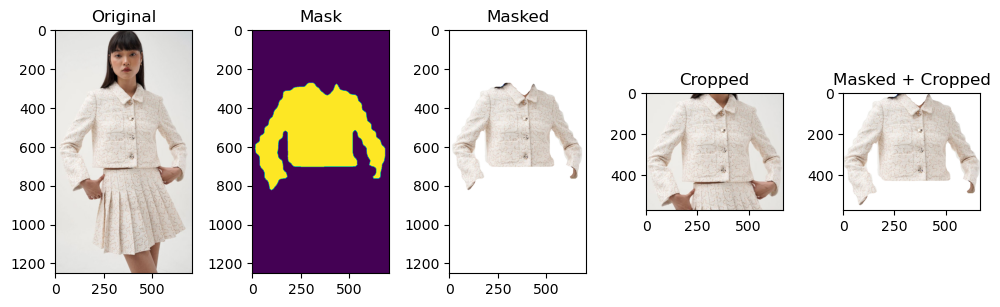

In [149]:
import pycocotools.mask as mask_util
import numpy as np
import matplotlib.pyplot as plt
import cv2

with open('datasets/fashionpedia_label_map.csv', 'r') as f:
    mapping = f.readlines()

for item_idx in range(len(output)):
    # item_idx=25
    for i in range(len(output[item_idx]['masks'])):    
        # if output[item_idx]['classes'][i] in (1,2,3):
            # 1:shirt, blouse
            # 2:top, t-shirt, sweatshirt
            # 3:sweater
    
            print(mapping[output[item_idx]['classes'][i] - 1], output[item_idx]['boxes'][i],  output[item_idx]['scores'][i])
            fig, ax = plt.subplots(1, 5, figsize=(10,10))
            img = cv2.imread(output[item_idx]['image_file'])
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[0].imshow(image)
            ax[0].set_title('Original')
    
             # Encoded mask string
            encoded_mask_string = output[item_idx]['masks'][i]
            
            # Decode the mask
            decoded_mask = mask_util.decode(encoded_mask_string)
            
            # Visualize the mask        
            ax[1].imshow(decoded_mask)        
            ax[1].set_title('Mask')
    
            masked_img = np.einsum('hwc,hw->hwc', image, decoded_mask)
            masked_img[masked_img == 0] = 255
            ax[2].imshow(masked_img)
            ax[2].set_title('Masked')
    
            #Crop to bounding boxes        
            y1, x1, y2, x2 = np.ceil(output[item_idx]['boxes'][i]).astype(int)
            crop_img = image[y1:y2, x1:x2]
            ax[3].imshow(crop_img)
            ax[3].set_title('Cropped')
    
            crop_masked_img = masked_img[y1:y2, x1:x2]
            crop_masked_img[crop_masked_img == 0] = 255
            ax[4].imshow(crop_masked_img)
            ax[4].set_title('Masked + Cropped')
           
            plt.tight_layout()
            plt.show()
